In [69]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

DEFAULT_RANDOM_SEED = 2021
def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

plt.style.use('bmh')
df = pd.read_csv('insurance.csv')

# Exploration du dataset

## Valeurs nulles

In [70]:
#Check empty values
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


<p style="text-align:justify;">On voit qu'aucune donnée n'est manquante dans le jeu de données.
Il nous faudra voir si toutes les données sont pertinentes, mais pour le moment, nous n'avons pas à en supprimer.</p>

## Cast des données de certaines colonnes

<p style="text-align:justify;">Afin de pouvoir analyser des données sous formes d'histogrammes, nous allons devoir transformer les données textuelles en int.
Il s'agit de "sex", "smoker" et "region". <br>
sex_male : female -> 0 et male -> 1 <br>
smoker_yes : no -> 0 et yes -> 1 <br>
region => southwest -> 0, southeast -> 1, northwest -> 2, northeast -> 3</p>

In [71]:
#Parse string to int
df['sex'] = df['sex'].replace({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].replace({'yes': 1, 'no': 0})
df['region'] = df['region'].replace({'southwest': 0, 'southeast': 1, 'northwest':2, 'northeast':3})

## Boxplots

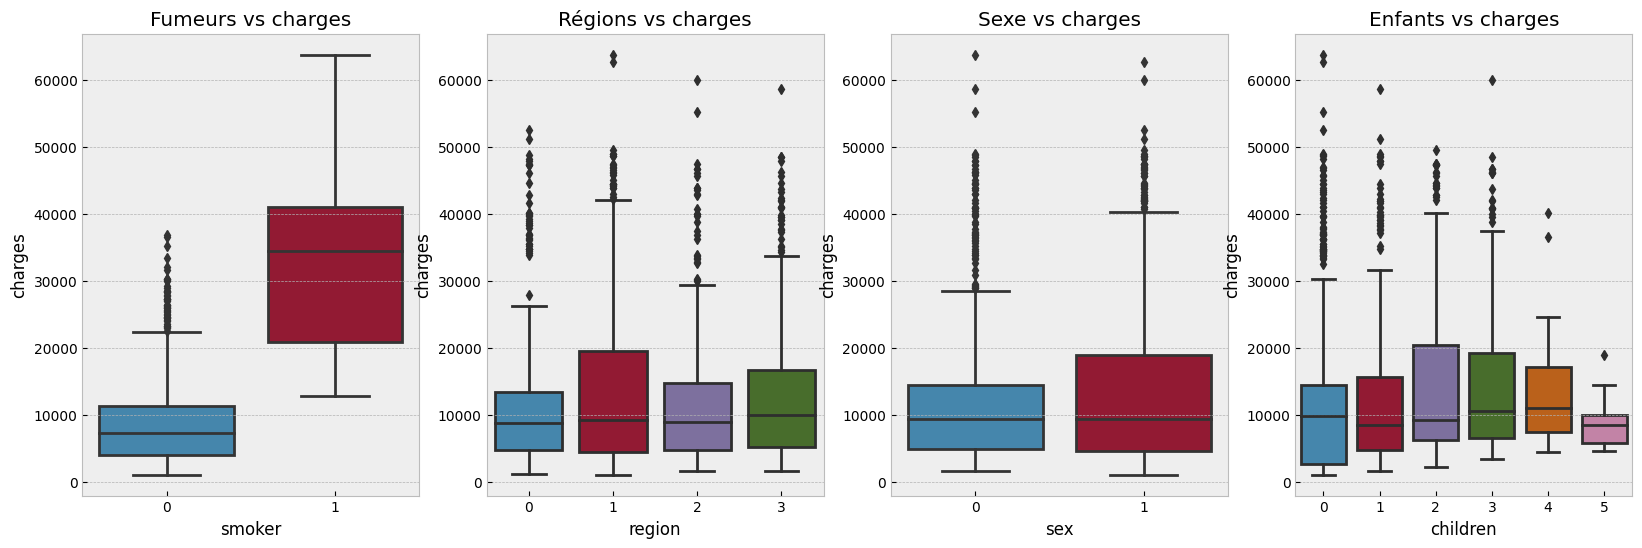

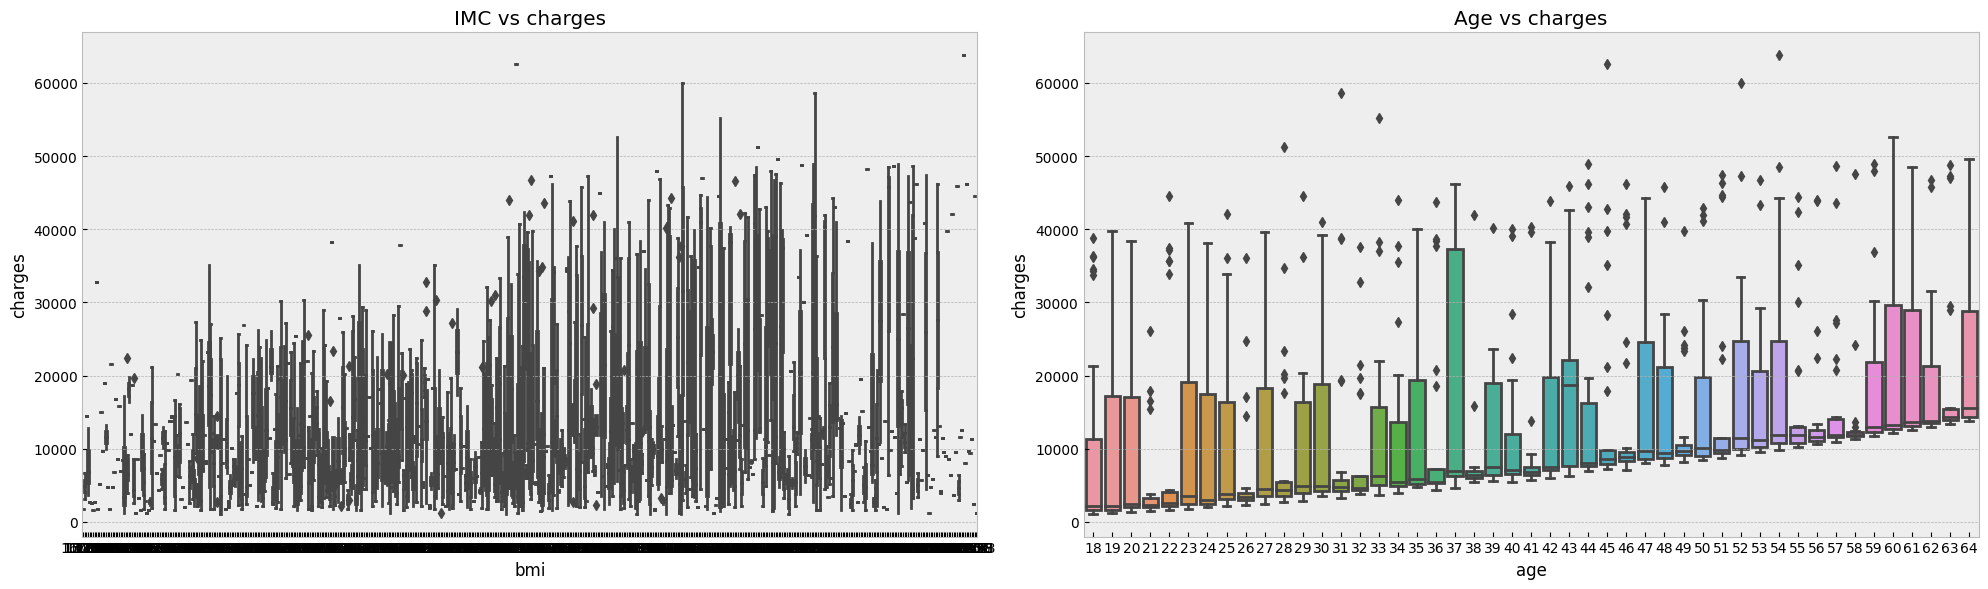

In [72]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

sns.boxplot(x='smoker', y='charges', data=df, ax=axes[0])
axes[0].set_title('Fumeurs vs charges')
df.groupby('smoker').agg(['mean','min','max'])['charges']

sns.boxplot(x='region', y='charges', data=df, ax=axes[1])
axes[1].set_title('Régions vs charges')
df.groupby('region').agg(['mean','min','max'])['charges']

sns.boxplot(x='sex', y='charges', data=df, ax=axes[2])
axes[2].set_title('Sexe vs charges')
df.groupby('sex').agg(['mean','min','max'])['charges']

sns.boxplot(x='children', y='charges', data=df, ax=axes[3])
axes[3].set_title('Enfants vs charges')
df.groupby('children').agg(['mean','min','max'])['charges']

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(x='bmi', y='charges', data=df, ax=axes[0])
axes[0].set_title('IMC vs charges')
df.groupby('bmi').agg(['mean','min','max'])['charges']

sns.boxplot(x='age', y='charges', data=df, ax=axes[1])
axes[1].set_title('Age vs charges')
df.groupby('age').agg(['mean','min','max'])['charges']


plt.tight_layout()

<p style="text-align:justify;">La médiane des charges des non-fumeurs est très largement inférieure à celles des fumeurs. Ce boxplot nous indique donc que les deux groupes ont des distributions de charges différentes, sans pour autant impliquer que le tabagisme est la cause de cette différence. En effet, il est possible que d'autres facteurs tels que l'âge, le sexe, le régime alimentaire ou les antécédents médicaux puissent influencer les niveaux de charges dans les deux groupes.

Pour le nombre d'enfants, on observe une augmentation de la valeur maximale de 0 à 2 enfants puis une diminution flagrante de 3 à 5 enfants. Cette différence s'explique sûrement par un accompagnement plus important des familles ayant plus d'enfants sans lequel les coûts seraient trop élevés.

La médiane des charges médicales payées pour chaque région est quasi-identique.

La médiane de charges médicales payées pour le sexe féminin et masculin est identique.

Le boxplot de l'IMC n'est pas très lisible mais nous remarquons une tendance haussière des charges médicales avec un IMC élevé.

On voit sur le boxplot de l'âge que plus celui-ci augmente, plus la valeur minimale et la médiane des frais médicaux sont élevées. Les différences observées en termes de 3ème quartile et de valeur maximale sont très probablement dûes à d'autres facteurs qui influencent les charges, ou alors à un manque de données.

Nous n'avons remarqué aucune valeur de colonnes aberrantes mis à part pour "Charges". Cependant, il nous semble possible que certaines personnes aient des frais médicaux anormalements élevés dans le cas de maladies graves par exemple.</p>

## Pairplots

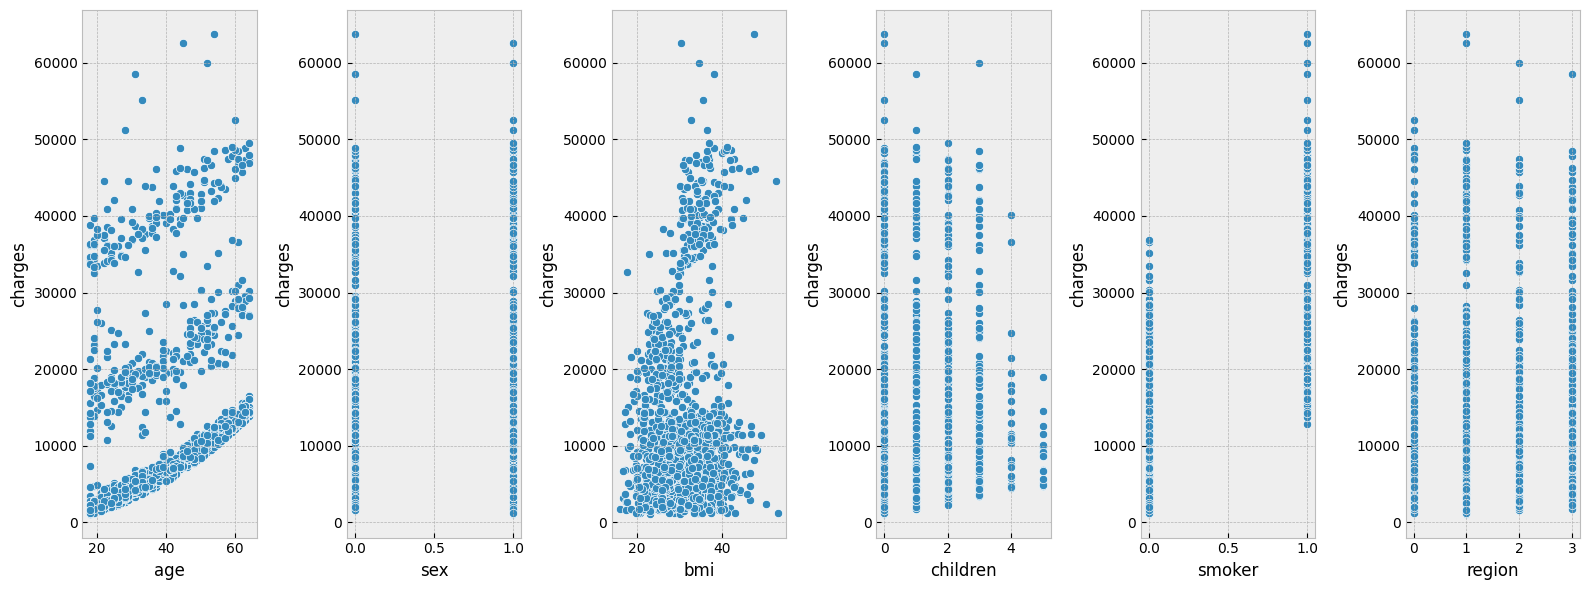

In [73]:
fig, axes = plt.subplots(1, 6, figsize=(16, 6))

sns.scatterplot(data=df, x='age', y='charges', ax=axes[0])
sns.scatterplot(data=df, x='sex', y='charges', ax=axes[1])
sns.scatterplot(data=df, x='bmi', y='charges', ax=axes[2])
sns.scatterplot(data=df, x='children', y='charges', ax=axes[3])
sns.scatterplot(data=df, x='smoker', y='charges', ax=axes[4])
sns.scatterplot(data=df, x='region', y='charges', ax=axes[5])

plt.tight_layout()

Nous avons pu observer les mêmes résultats que sur les boxplots précédents avec une autre visualisation.

## Corrélations

<Axes: >

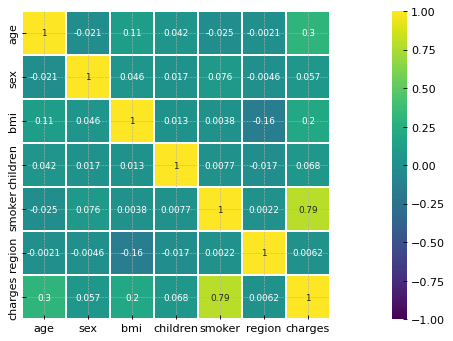

In [74]:
corr = df.corr()  # We already examined Charges correlations
plt.figure(figsize=(20, 5), dpi=80)

sns.heatmap(corr,
            cmap='viridis',
            vmax=1.0,
            vmin=-1.0,
            linewidths=0.1,
            annot=True,
            annot_kws={"size": 8},
            square=True)

On peut remarquer qu'il y a 4 valeurs peu corrélées avec les charges, 1 moyennenement corrélée et 1 fortement corrélée<br>
Faiblement : <br>
bmi         : $0.198341$ <br>
children    : $0.067998$ <br>
sex         : $0.057292$ <br>
region      : $0.006208$ <br>
Moyennement : <br>
age         : $0.299008$ <br><br>
Fortement : <br>
smoker      : $0.787251$ <br><br>

Les autres colonnes sont peu corrélées entre elles. Les corrélations les plus élevées sont :<br>
BMI - region : $0.16$<br>
BMI - age : $0.11$<br>

## Split du jeu de données en jeu d'entraînement et de test

<p style="text-align:justify;">Nous allons débuter par diviser notre jeu de données en un jeu d'entraînement et un jeu de tests.
30% des données seront de test, et 70% seront d'entraînement.
Le random_state nous garantit que les mêmes jeux de données sont obtenues à chaque exécution du code. C'est particulièrement important pour la reproductibilité des résultats dans les expériences de machine learning. Nous l'avons fixé arbitrairement à 2021.</p>

In [75]:
X = df.drop(['charges'], axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=2021)

X_train: DataFrame contenant les données d'entraînement pour les variables explicatives (toutes les colonnes de 'df' à l'exception de 'charges').<br>
y_train: une série contenant les données d'entraînement pour la variable cible (la colonne 'charges').<br>
X_test: un DataFrame contenant les données de test pour les variables explicatives.<br>
y_test: une série contenant les données de test pour la variable cible.<br>

Nous allons maintenant entraîner un modèle à trouver un lien entre y_train (sorties) et X_train (entrées)

# Entraînement

<p style="text-align:justify;">Nous commençons par effectuer une mise à l'échelle des jeux de données X, afin de ne pas créer d'inéquités entre les grandes et les petites valeurs.</p>

In [76]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Construction des modèles


<p style="text-align:justify;">Nous débutons par le modèle de régression linéaire car c'est l'une des méthodes de régression les plus simples. L'un de ses principaux avantages est la facilité d'interprétation des résultats.</p>

### Modèle de régression linéaire

In [77]:
#Création d'un objet modeleRegressionLineaire de régression linéaire
modeleRegressionLineaire = LinearRegression()

#Entraînement du modèle sur les données d'entraînement
#Pour obtenir les meilleures pondérations, une minimisation de la somme des carrés des résidus (SSR) sera cherchée, pour toutes les observations.
modeleRegressionLineaire.fit(X_train_scaled, y_train)

LinearRegression()

### Modèle de régression lasso

<p style="text-align:justify;">Afin de choisir le meilleur hyperparamètre alpha, nous allons effectuer une "K Fold Cross-Validation".</p>

In [78]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso

kf = KFold(n_splits=10, shuffle=True)

#Valeurs de alpha à tester
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 75, 100, 500, 1000]
scores = []

for alpha in alphas:
    alpha_scores = []
    #K Fold cross validation : chacun des 10 plis sera jeu de validation
    for train_index, val_index in kf.split(X_train_scaled, y_train):

        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]
       
        #Création d'un objet modeleRegressionLasso de régression Lasso
        modeleRegressionLasso = Lasso(alpha=alpha)
        modeleRegressionLasso.fit(X_train_fold, y_train_fold)
        score = modeleRegressionLasso.score(X_val_fold, y_val_fold)
        alpha_scores.append(score)

    # Calculer la moyenne des scores de validation
    mean_score = np.mean(alpha_scores)
    scores.append(mean_score)

# Trouver l'alpha qui donne le meilleur score de validation
best_alpha_lasso = alphas[np.argmax(scores)]   
print("Pour Lasso, le meilleur alpha est : ",best_alpha_lasso, "Le score est ", max(scores))

# Nouvel entrainement avec le meilleur alpha
del modeleRegressionLasso
modeleRegressionLasso = Lasso(alpha=best_alpha_lasso)
modeleRegressionLasso.fit(X_train_scaled, y_train)

Pour Lasso, le meilleur alpha est :  100 Le score est  0.7361485864910959


Lasso(alpha=100)

Nous avons observé que le meilleur alpha varie beaucoup d'une exécution à l'autre, et que le score maximal est approximativement toujours le même ($0.74$). On peut imaginer que la régularisation n'a pas d'impact.

### Modèle de régression ridge

<p style="text-align:justify;">Nous allons utiliser les jeux d'entraînement mis à l'échelle, et effectuer une "K Fold Cross-Validation".</p>

In [109]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso

kf = KFold(n_splits=10, shuffle=True)

#Valeurs de alpha à tester
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 75, 100, 500, 1000]
scores = []

for alpha in alphas:
    # Initialiser une liste pour stocker les scores de validation pour ce modèle
    alpha_scores = []
    # Parcourir les différentes itérations de la validation croisée
    for train_index, val_index in kf.split(X_train_scaled, y_train):
        # Extraire les données d'entraînement et de validation pour cette itération

        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]
       
        # Créer un modèle Ridge avec l'alpha actuel et entraîner le modèle sur les données d'entraînement
        modeleRegressionLineaireRidge = Ridge(alpha=alpha)
        modeleRegressionLineaireRidge.fit(X_train_fold, y_train_fold)
        # Calculer le score de validation pour ce modèle et l'ajouter à la liste des scores pour cette alpha
        score = modeleRegressionLineaireRidge.score(X_val_fold, y_val_fold)
        alpha_scores.append(score)
    # Calculer la moyenne des scores de validation pour ce modèle et l'ajouter à la liste des scores pour tous les alphas
    mean_score = np.mean(alpha_scores)
    scores.append(mean_score)

# Trouver l'alpha qui donne le meilleur score de validation
best_alpha_ridge = alphas[np.argmax(scores)]
print("Pour Ridge, le meilleur alpha est : ",best_alpha_ridge, "Le score est ", max(scores))

# Nouvel entrainement avec le meilleur alpha
del modeleRegressionLineaireRidge
modeleRegressionLineaireRidge = Ridge(alpha=best_alpha_ridge)
modeleRegressionLineaireRidge.fit(X_train_scaled, y_train)

Pour Ridge, le meilleur alpha est :  1 Le score est  0.7350901034567097


Ridge(alpha=1)

Tout comme pour le modèle de régression Lasso, nous observons que le meilleur alpha varie beaucoup d'une exécution à l'autre, et que le score maximal est approximativement toujours le même ($0.74$). On peut imaginer que la régularisation n'a pas d'impact.

### Modèle de régression linéaire/ridge polynome

<p style="text-align:justify;">Nous avons essayé de réaliser une régression linéaire avec un polynome de degré autre que 1, sans régularisation, mais nous avons obtenu des coefficients extrêmement grands. Cela peut faire référence à du sur-apprentissage. Nous allons donc régulariser via une Ridge Regression au lieu d'une Régression linéaire afin de restreindre les coefficients. En utilisant RidgeCV, une K Fold Cross Validation sera effectuée automatiquement sous la forme d'un "leave-one-out cross-validation", c'est-à-dire qu'il y aura autant de plis que de points dans le dataset.</p>

In [113]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV

kf = KFold(n_splits=6, shuffle=True)

degrees = [1,2,3,4,5,6]
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 75, 100, 500, 1000]
scores = []

for degree in degrees:

    degree_scores = []
    poly = PolynomialFeatures(degree=degree)

    for train_index, val_index in kf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

        X_poly_scaled = poly.fit_transform(X_train_fold)
        #Ajout d'une colonne de biais
        X_poly_scaled = np.hstack((np.ones((X_poly_scaled.shape[0], 1)), X_poly_scaled))

        modeleRegressionPolynomiale = RidgeCV(alphas)
        modeleRegressionPolynomiale.fit(X_poly_scaled, y_train_fold)

        X_poly_scaled_val = poly.transform(X_val_fold) #Transformer X_val_fold en polynôme
        X_poly_scaled_val = np.hstack((np.ones((X_poly_scaled_val.shape[0], 1)), X_poly_scaled_val)) # Ajouter une colonne de biais

        score = modeleRegressionPolynomiale.score(X_poly_scaled_val, y_val_fold) # Calculer le score sur X_val_fold transformé en polynôme
        degree_scores.append(score)
    
    mean_score = np.mean(degree_scores)
    scores.append(mean_score)

# Trouver le degré qui donne le meilleur score de validation
best_degree_polynomial_regression = degrees[np.argmax(scores)]   
print("Pour Régression polynomiale, le meilleur degré est : ",best_degree_polynomial_regression)

# Nouvel entrainement avec le meilleur degré
del poly
poly = PolynomialFeatures(degree=best_degree_polynomial_regression)
X_poly_scaled = poly.fit_transform(X_train_scaled)
X_poly_scaled = np.hstack((np.ones((X_poly_scaled.shape[0], 1)), X_poly_scaled))
modeleRegressionPolynomiale = RidgeCV(alphas=alphas)
modeleRegressionPolynomiale.fit(X_train_scaled, y_train)
meilleur_alpha = modeleRegressionPolynomiale.alpha_

# Entraîner le modèle avec le meilleur alpha
modeleRegressionPolynomiale_final = Ridge(alpha=meilleur_alpha)
modeleRegressionPolynomiale.fit(X_poly_scaled, y_train)

Pour Régression polynomiale, le meilleur degré est :  2


RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 5, 10, 50, 75, 100, 500, 1000])

Ici, la valeur du meilleur hyperparamètre change très peu, on obtient la plupart du temps le degré 2.

### Modèle Random Forest

<p style="text-align:justify;">Le modèle Random Forest est un modèle plus complexe que les précédents impliquant une forêt d'arbres de décision indépendants. Plus il y a d'arbres dans la forêt, et plus le modèle sera précis. Afin de trouver un bon équilibre entre un bon hyperparamètre et un temps d'exécution pas trop élevé, nous avons choisi de fixer ne nombre d'arbres à 100.</p>

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

nbTrees = 100

# instantiate the regressor 
rfr = RandomForestRegressor(n_estimators=nbTrees, random_state=2021)

# fit the model
rfr.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=2021)

### Ce que disent les modèles


In [119]:
for idx, col_name in enumerate(X_train.columns):
    print("Coefficients Betas de {} =>\n[regression Linéaire] {} \n[regression Lasso alpha = {}] {}\n[regression Ridge alpha = {}] {} \n[regression Ridge polynome degré = {}] {}\n".format(
        col_name, modeleRegressionLineaire.coef_[idx], best_alpha_lasso, modeleRegressionLasso.coef_[idx],best_alpha_ridge,modeleRegressionLineaireRidge.coef_[idx], best_degree_polynomial_regression, modeleRegressionPolynomiale.coef_[idx]))

Coefficients Betas de age =>
[regression Linéaire] 3319.906630471436 
[regression Lasso alpha = 100] 3229.8729562098983
[regression Ridge alpha = 1] 3316.1902572879453 
[regression Ridge polynome degré = 2] 0.0

Coefficients Betas de sex =>
[regression Linéaire] -114.56407872892441 
[regression Lasso alpha = 100] -0.0
[regression Ridge alpha = 1] -113.6804873818613 
[regression Ridge polynome degré = 2] 0.0

Coefficients Betas de bmi =>
[regression Linéaire] 2163.9333875205075 
[regression Lasso alpha = 100] 2048.6240411778886
[regression Ridge alpha = 1] 2161.7630686061543 
[regression Ridge polynome degré = 2] 3525.5028371734707

Coefficients Betas de children =>
[regression Linéaire] 827.0786426825136 
[regression Lasso alpha = 100] 728.7349531362855
[regression Ridge alpha = 1] 826.3110687979087 
[regression Ridge polynome degré = 2] -242.6998762973946

Coefficients Betas de smoker =>
[regression Linéaire] 9572.732819313442 
[regression Lasso alpha = 100] 9461.620335555579
[regress

<p style="text-align:justify;">Régression linéaire : Les variables age, bmi et region ont toutes un effet positif sur la variable cible Charges, et le nombre d'enfants ainsi que le tabagisme ont un effet encore plus positif. Il convient également de noter que le coefficient de la variable smoker est beaucoup plus élevé que celui des autres variables, ce qui indique que le modèle considère que le tabagisme a un effet beaucoup plus important sur les coûts de santé que les autres variables. A l'inverse, l'âge a un impact négatif.

Régression Lasso: Toutes les variables à l'exception du sexe, qui n'a aucun impact, ont un effet positif sur la variable Charges. Il convient de noter que, comme précédémment, c'est le tabagisme qui a l'effet plus élevé. L'âge a aussi un impact très important.

Régression Ridge: Toutes les variables, à l'exception de sex ont un impact positif sur les charges. Comme précédemment, la variable smoker est considerée comme la plus importante pour les coûts de santé.

Régression Ridge sur un polynome d'autre degré que 1 : Il est intéressant de noter que cette fois-ci, ce n'est pas la variables smoker qui a le plus d'importance sur les charges, mais bmi. Elle est suivie de smoker, puis de région. Age et sex n'ont quant à elle aucun impact, et le nombre d'enfants a un impact négatif sur la prévision.

On ne peut pas comparer cela au modèle Random Forest puisqu'il ne fonctionne pas avec des coefficients comme les autres modèles.

On peut conclure que certaines variables sortent du lot, montrant une importance récurrente quant aux coûts de santé. Il s'agit du tabagisme, du bmi et du nombre d'enfants. </p>

In [83]:
for idx, col_name in enumerate(X_train.columns):
    print("Valeurs intercept de {} =>\n[regression Linéaire] {} \n[regression Lasso alpha = {}] {}\n[regression Ridge alpha = {}] {} \n[regression Ridge polynome degré = {}] {}\n".format(
        col_name, modeleRegressionLineaire.intercept_, best_alpha_lasso, modeleRegressionLasso.intercept_,best_alpha_ridge,modeleRegressionLineaireRidge.intercept_, best_degree_polynomial_regression, modeleRegressionPolynomiale.intercept_))

Valeurs intercept de age =>
[regression Linéaire] 13232.207095629274 
[regression Lasso alpha = 100] 13232.207095629274
[regression Ridge alpha = 0.01] 13232.207095629274 
[regression Ridge polynome degré = 2] 8298.26035795738

Valeurs intercept de sex =>
[regression Linéaire] 13232.207095629274 
[regression Lasso alpha = 100] 13232.207095629274
[regression Ridge alpha = 0.01] 13232.207095629274 
[regression Ridge polynome degré = 2] 8298.26035795738

Valeurs intercept de bmi =>
[regression Linéaire] 13232.207095629274 
[regression Lasso alpha = 100] 13232.207095629274
[regression Ridge alpha = 0.01] 13232.207095629274 
[regression Ridge polynome degré = 2] 8298.26035795738

Valeurs intercept de children =>
[regression Linéaire] 13232.207095629274 
[regression Lasso alpha = 100] 13232.207095629274
[regression Ridge alpha = 0.01] 13232.207095629274 
[regression Ridge polynome degré = 2] 8298.26035795738

Valeurs intercept de smoker =>
[regression Linéaire] 13232.207095629274 
[regressio

<p style="text-align:justify;">Ce résultat indique la charge moyenne pour une personne lorsque toutes les variables explicatives (âge, sexe, IMC, nombre d'enfants, tabagisme et région) ont la valeur de la moyenne.</p>

### Evaluation quantitative des modèles

Nous commencons par calculer le coefficient de détermination $R^2$ du modèle.
Il indique dans quelle mesure la variation de $y$ peut être expliquée par la dépendance à $X$, en utilisant le modèle de régression en question. Un $R^2$ plus grand indique une meilleure adéquation et signifie que le modèle peut mieux expliquer la variation de la production avec différentes entrées. Par exemple, un $R^2$ égal à 1 corresponds à $SSR = 0$. Il s'agit d'un ajustement parfait, puisque les valeurs des réponses prédites et réelles s'accordent parfaitement entre elles.

In [84]:
X_poly_scaled_test = poly.fit_transform(X_test_scaled)
#Ajout d'une colonne de biais pour le polynôme
X_poly_scaled_test = np.hstack((np.ones((X_poly_scaled_test.shape[0], 1)), X_poly_scaled_test))

print("Scores des modèles \n[regression lineaire] {} \n[regression Lasso alpha = {}] {}\n[regression Ridge alpha = {}] {} \n[regression Ridge polynome degré = {}] {}\n[regression Random forest nbTrees = {}] {}\n".format(
modeleRegressionLineaire.score(X_test_scaled, y_test),
best_alpha_lasso, modeleRegressionLasso.score(X_test_scaled, y_test),
best_alpha_ridge, modeleRegressionLineaireRidge.score(X_test_scaled, y_test),
best_degree_polynomial_regression, modeleRegressionPolynomiale.score(X_poly_scaled_test, y_test),
nbTrees, rfr.score(X_test_scaled, y_test)))

Scores des modèles 
[regression lineaire] 0.7588962059664797 
[regression Lasso alpha = 100] 0.759152100600557
[regression Ridge alpha = 0.01] 0.7588958352551819 
[regression Ridge polynome degré = 2] 0.8569299769591812
[regression Random forest nbTrees = 100] 0.8433544629543215



Un $R^2$ de $0,76$ indique que le modèle de régression linéaire est capable d'expliquer $76$% de la variance de la variable cible en utilisant les variables explicatives. Le modèle est donc relativement performant.
On peut remarquer le classement suivant, en termes de $R^2$ et dans l'ordre croissant: Régression linéaire, Régression Ridge, Régression Lasso, Régression Random Forest et Régression Ridge polynome autre que degré 1. On remarque néanmoins un fossé qui se creuse entre les 3 premiers, qui ont un score très rapproché (environ 0,75) et les deux derniers (environ 0,85).<br>
Si on utilise un modèle plus complexe mais qu'on l'exploite à pleine capacité - c'est-à-dire avec la validation croisée - alors on peut obtenir des résultats très intéressants, d'où la valeur de $R^2$ pour le modèle Random Forest et la Régression Ridge pour un polynôme de degré supérieur à 1.

En revanche, $R^2$ ne suffit pas à évaluer la qualité du modèle. Nous allons donc analyser d'autres éléments.

### Evaluation qualitative des modèles

On peut voir que le modèle suit plus ou moins la droite des y=x pour des charges inféireures à 15 000 euros, mais après, les valeurs s'éloignent plus de cette droite.

In [85]:
predictionChargesRegressionLineaires = modeleRegressionLasso.predict(X_test_scaled)
predictionChargesRegressionLineairesLasso = modeleRegressionLasso.predict(X_test_scaled)
predictionChargesRegressionLineairesRidge = modeleRegressionLineaireRidge.predict(X_test_scaled)
predictionChargesRegressionPolynomiale = modeleRegressionPolynomiale.predict(X_poly_scaled_test)
predictionChargesRegressionRandomForest = rfr.predict(X_test_scaled)

Text(0.5, 0.98, 'Dispersion des résidus')

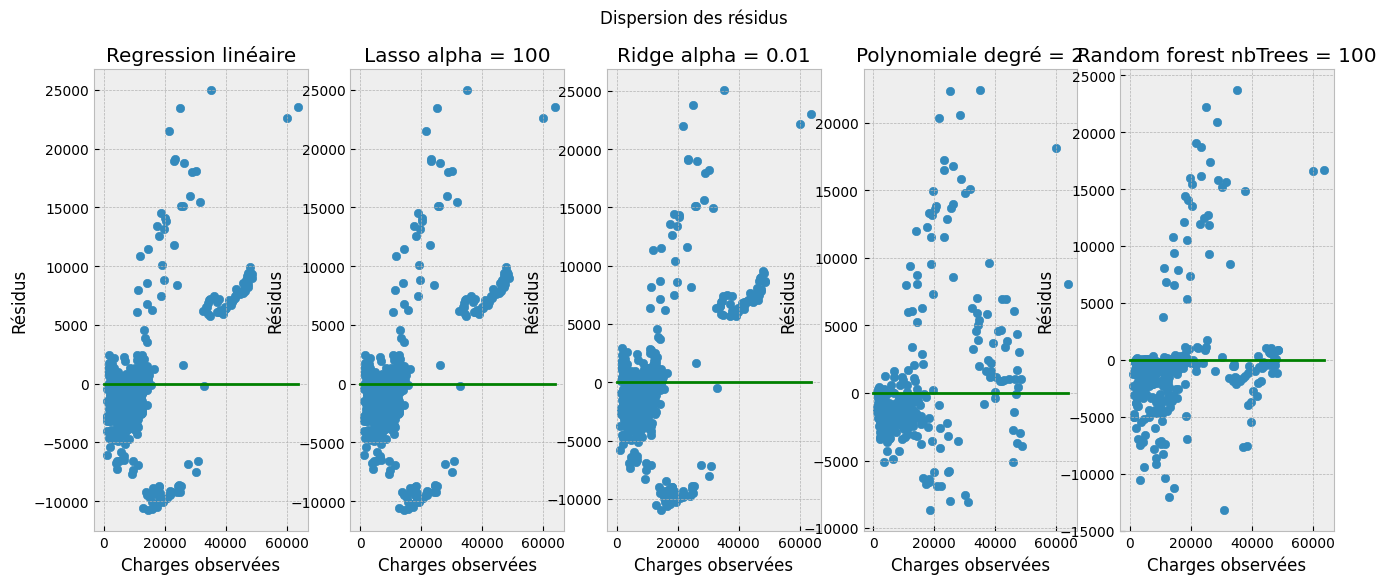

In [86]:
residusRegressionLineaire = y_test - predictionChargesRegressionLineaires
residusRegressionLasso = y_test - predictionChargesRegressionLineairesLasso
residusRegressionRidge = y_test - predictionChargesRegressionLineairesRidge
residusRegressionPolynomiale = y_test - predictionChargesRegressionPolynomiale
residusRegressionRandomForest = y_test - predictionChargesRegressionRandomForest

fig, axes = plt.subplots(1, 5, figsize=(16, 6)) # spécifie la taille de la figure
axes[0].scatter(y_test, residusRegressionLineaire)
axes[0].set_xlabel("Charges observées")
axes[0].set_ylabel("Résidus")
axes[0].set_title("Regression linéaire")
axes[0].plot([0, max(y_test)], [0, 0], color='g')

axes[1].scatter(y_test, residusRegressionLasso)
axes[1].set_xlabel("Charges observées")
axes[1].set_ylabel("Résidus")
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))
axes[1].plot([0, max(y_test)], [0, 0], color='g')

axes[2].scatter(y_test, residusRegressionRidge)
axes[2].set_xlabel("Charges observées")
axes[2].set_ylabel("Résidus")
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))
axes[2].plot([0, max(y_test)], [0, 0], color='g')

axes[3].scatter(y_test, residusRegressionPolynomiale)
axes[3].set_xlabel("Charges observées")
axes[3].set_ylabel("Résidus")
axes[3].set_title("Polynomiale degré = {}".format(best_degree_polynomial_regression))
axes[3].plot([0, max(y_test)], [0, 0], color='g')

axes[4].scatter(y_test, residusRegressionRandomForest)
axes[4].set_xlabel("Charges observées")
axes[4].set_ylabel("Résidus")
axes[4].set_title("Random forest nbTrees = {}".format(nbTrees))
axes[4].plot([0, max(y_test)], [0, 0], color='g')

fig.suptitle("Dispersion des résidus")

<p style="text-align:justify;">On peut observer des valeurs de résidus très importantes. À ce stade, on ne peut pas toutes les supprimer puisqu'on se rend compte qu'elles sont trop nombreuses. On voit particulièrement un groupe d'outliers autour des charges prédites à 30 000 euros, avec des résidus de -10 000 euros, signifiant que notre modèle a surestimé de 10 000 euros les charges, ce qui est très excessif. On peut aussi observer des valeurs d'extrêmes sous-estimations d'environ 20 000 euro pour des prédictions de 10 000 euros.</p>

In [87]:
import statistics

print("Moyenne des résidus =>\n[regression lineaire] {} \n[regression Lasso alpha = {}] {}\n[regression Ridge alpha = {}] {} \n[regression Ridge polynome degré = {}] {}\n [regression Random forest nbTrees = {}] {}\n".format(
    statistics.mean(residusRegressionLineaire), best_alpha_lasso,statistics.mean(residusRegressionLasso), best_alpha_ridge, statistics.mean(residusRegressionRidge),best_degree_polynomial_regression, statistics.mean(residusRegressionPolynomiale), nbTrees, statistics.mean(residusRegressionRandomForest)))

print("Variance des résidus =>\n[regression lineaire] {} \n[regression Lasso alpha = {}] {}\n[regression Ridge alpha = {}] {} \n[regression Ridge polynome degré = {}] {}\n[regression Random forest nbTrees = {}] {}\n".format(
    statistics.variance(residusRegressionLineaire), best_alpha_lasso, statistics.variance(residusRegressionLasso),best_alpha_ridge, statistics.variance(residusRegressionRidge), best_degree_polynomial_regression,  statistics.variance(residusRegressionPolynomiale), nbTrees, statistics.variance(residusRegressionRandomForest)))

Moyenne des résidus =>
[regression lineaire] 127.19377315182047 
[regression Lasso alpha = 100] 127.19377315182047
[regression Ridge alpha = 0.01] 127.19377315182027 
[regression Ridge polynome degré = 2] 77.03769936352926
 [regression Random forest nbTrees = 100] -312.6643516457478

Variance des résidus =>
[regression lineaire] 37153499.276002385 
[regression Lasso alpha = 100] 37153499.276002385
[regression Ridge alpha = 0.01] 37193048.34665203 
[regression Ridge polynome degré = 2] 22073846.00785773
 [regression Random forest nbTrees = 100] 24076882.83034935



On peut remarquer que la moyenne des résidus de la régression Ridge à polynome autre que 1 est la plus faible, et est plutôt satisfaisante. En moyenne, tous sauf Random Forest ont tendance à surestimer les coûts de santé. Aussi, on voit que la variance des résidus n'est pas homogène.

<p style="text-align:justify;">Nous allons visualiser la distribution des erreurs de prédiction de notre modèle de régression linéaire, c'est-à-dire la différence entre les valeurs réelles de la variable cible (y_test) et les valeurs prédites par le modèle (predictionChargesRegressionLineaires).
Si l'histogramme des écarts obtenus est centré autour de zéro et suit une distribution normale, cela signifie que les erreurs de prédiction sont faibles et que notre modèle est capable de faire des prédictions précises. En revanche, si l'histogramme présente une distribution asymétrique ou est centré autour d'une valeur non nulle, cela peut indiquer la présence de biais ou d'erreurs systématiques dans notre modèle.</p>

Text(0.5, 0.98, 'Répartition des résidus')

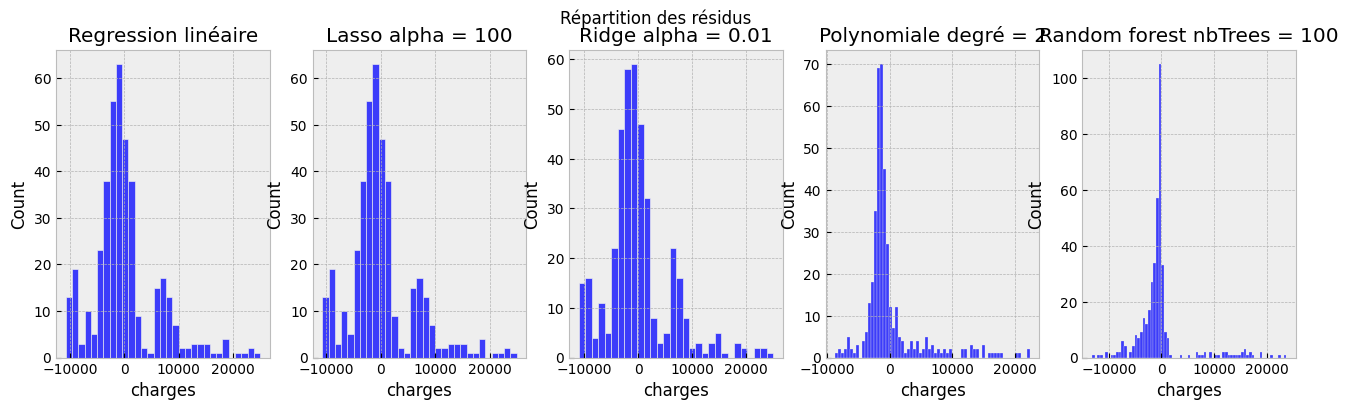

In [88]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4)) # spécifie la taille de la figure

# Tracer l'histogramme pour la régression linéaire
sns.histplot(residusRegressionLineaire, color='blue', ax=axes[0])
axes[0].set_title("Regression linéaire")

# Tracer l'histogramme pour la régression Lasso
sns.histplot(residusRegressionLasso, color='blue', ax=axes[1])
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))

# Tracer l'histogramme pour la régression Ridge
sns.histplot(residusRegressionRidge, color='blue', ax=axes[2])
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))

# Tracer l'histogramme pour la régression Polynomiale
sns.histplot(residusRegressionPolynomiale, color='blue', ax=axes[3])
axes[3].set_title("Polynomiale degré = {}".format(best_degree_polynomial_regression))

# Tracer l'histogramme pour la régression Random forest
sns.histplot(residusRegressionRandomForest, color='blue', ax=axes[4])
axes[4].set_title("Random forest nbTrees = {}".format(nbTrees))

plt.suptitle("Répartition des résidus")

<p style="text-align:justify;">Tous les modèles présentent des histogrammes centrés autour de 0, ce qui indique qu'il y a de nombreuses bonnes estimations dans ces modèles entraînés. En revanche, tous ne s'étendent pas uniformément sur les deux côtés. On reconnaît que Random Forest sous-estime la plupart du temps les charges.</p>

Text(0.5, 0.98, 'Mise en parallèle des valeurs prédites et observées')

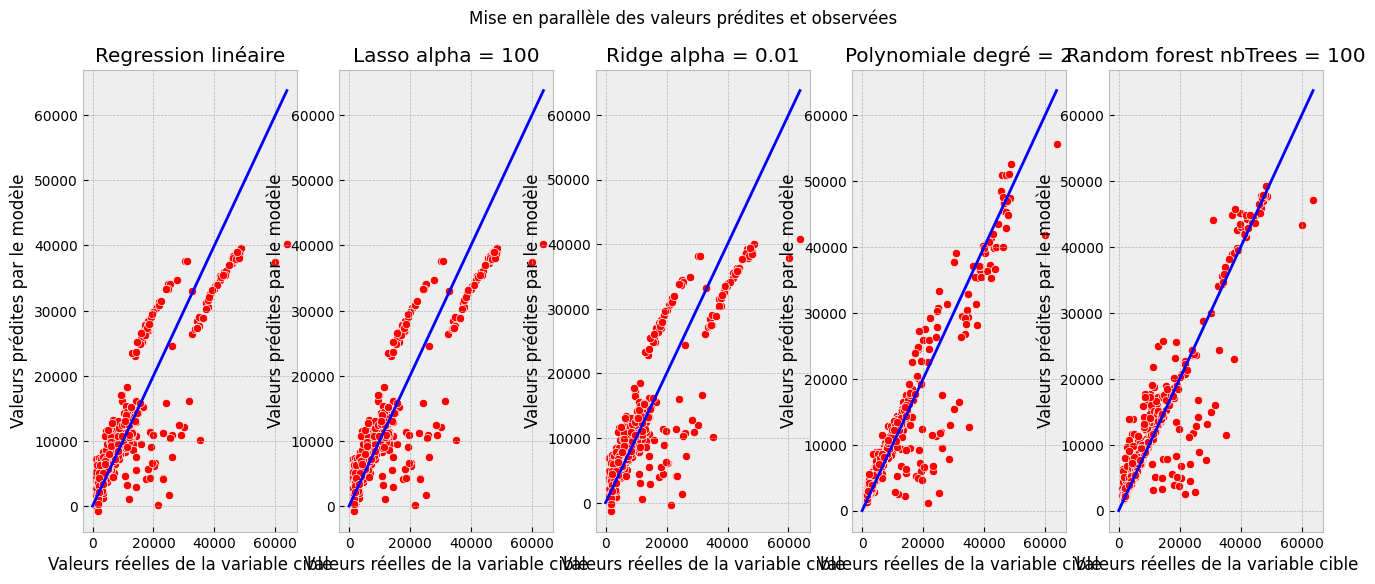

In [89]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6)) # spécifie la taille de la figure
sns.scatterplot(ax=axes[0], x=y_test, y=predictionChargesRegressionLineaires, color='r')
axes[0].set_xlabel("Valeurs réelles de la variable cible")
axes[0].set_ylabel("Valeurs prédites par le modèle")
axes[0].set_title("Regression linéaire")
axes[0].plot([0, max(y_test)], [0, max(y_test)], color='b')

sns.scatterplot(ax=axes[1], x=y_test, y=predictionChargesRegressionLineairesLasso, color='r')
axes[1].set_xlabel("Valeurs réelles de la variable cible")
axes[1].set_ylabel("Valeurs prédites par le modèle")
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))
axes[1].plot([0, max(y_test)], [0, max(y_test)], color='b')

sns.scatterplot(ax=axes[2], x=y_test, y=predictionChargesRegressionLineairesRidge, color='r')
axes[2].set_xlabel("Valeurs réelles de la variable cible")
axes[2].set_ylabel("Valeurs prédites par le modèle")
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))
axes[2].plot([0, max(y_test)], [0, max(y_test)], color='b')

sns.scatterplot(ax=axes[3], x=y_test, y=predictionChargesRegressionPolynomiale, color='r')
axes[3].set_xlabel("Valeurs réelles de la variable cible")
axes[3].set_ylabel("Valeurs prédites par le modèle")
axes[3].set_title("Polynomiale degré = {}".format(best_degree_polynomial_regression))
axes[3].plot([0, max(y_test)], [0, max(y_test)], color='b')


sns.scatterplot(ax=axes[4], x=y_test, y=predictionChargesRegressionRandomForest, color='r')
axes[4].set_xlabel("Valeurs réelles de la variable cible")
axes[4].set_ylabel("Valeurs prédites par le modèle")
axes[4].set_title("Random forest nbTrees = {}".format(nbTrees))
axes[4].plot([0, max(y_test)], [0, max(y_test)], color='b')
plt.suptitle("Mise en parallèle des valeurs prédites et observées")

On observe sur les graphes ci-dessus que plus le modèle est complexe et plus les valeurs sont resserrées autour de la fonction linéaire $y = x$, la première bissectrice. Ainsi, cela montre une prédiction fiable par rapport aux valeurs réelles, principalement pour les deux derniers modèles, à savoir Random Forest et Régression Ridge avec un polynome de degré supérieur à 1.

Text(0.5, 1.0, 'nbTrees = 100')

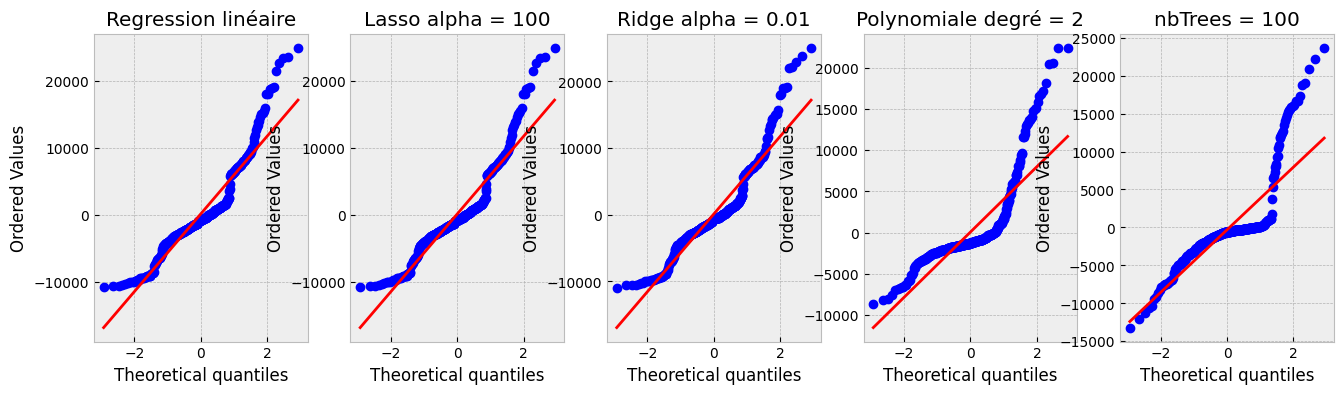

In [90]:
import scipy as sp


fig, axes = plt.subplots(1, 5, figsize=(16,4)) # spécifie la taille de la figure

# Tracer le graphique de probabilité normale pour la régression linéaire
_, (_, _, r) = sp.stats.probplot(residusRegressionLineaire, fit=True, plot=axes[0])
axes[0].set_title('Regression linéaire')

# Tracer le graphique de probabilité normale pour la régression linéaire Lasso
_, (_, _, r) = sp.stats.probplot(residusRegressionLasso, fit=True, plot=axes[1])
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))

# Tracer le graphique de probabilité normale pour la régression linéaire Ridge
_, (_, _, r) = sp.stats.probplot(residusRegressionRidge, fit=True, plot=axes[2])
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))

# Tracer le graphique de probabilité normale pour la régression linéaire polynomiale
_, (_, _, r) = sp.stats.probplot(residusRegressionPolynomiale, fit=True, plot=axes[3])
axes[3].set_title("Polynomiale degré = {}".format(best_degree_polynomial_regression))

# Tracer le graphique de probabilité normale pour la régression Random forest
_, (_, _, r) = sp.stats.probplot(residusRegressionRandomForest, fit=True, plot=axes[4])
axes[4].set_title("nbTrees = {}".format(nbTrees))

<p style="text-align:justify;">Puisque les points sont proches de la droite, alors on valide l'hypothèse gaussienne.</p>

#### Homostédasticité

Text(0.5, 1.0, 'Polynomiale degré = 100')

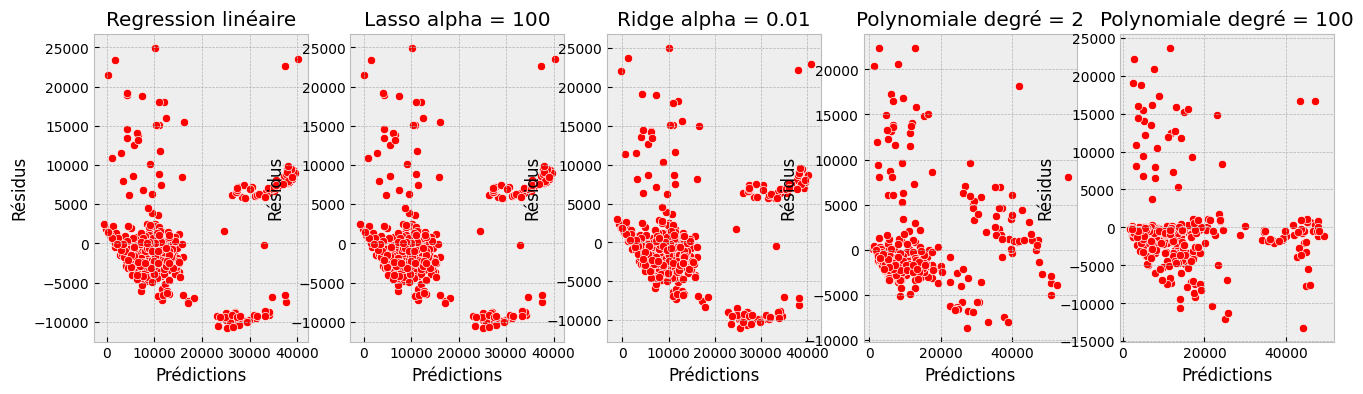

In [91]:
fig, axes = plt.subplots(1, 5, figsize=(16,4)) # spécifie la taille de la figure

# Tracer la dispersion des résidus pour la régression linéaire
sns.scatterplot(y=residusRegressionLineaire, x=predictionChargesRegressionLineaires, color='r', ax=axes[0])
axes[0].set_xlabel("Prédictions")
axes[0].set_ylabel("Résidus")
axes[0].set_title("Regression linéaire")

# Tracer la dispersion des résidus pour la régression linéaire Lasso
sns.scatterplot(y=residusRegressionLasso, x=predictionChargesRegressionLineairesLasso, color='r', ax=axes[1])
axes[1].set_xlabel("Prédictions")
axes[1].set_ylabel("Résidus")
axes[1].set_title("Lasso alpha = {}".format(best_alpha_lasso))

# Tracer la dispersion des résidus pour la régression linéaire Ridge
sns.scatterplot(y=residusRegressionRidge, x=predictionChargesRegressionLineairesRidge, color='r', ax=axes[2])
axes[2].set_xlabel("Prédictions")
axes[2].set_ylabel("Résidus")
axes[2].set_title("Ridge alpha = {}".format(best_alpha_ridge))

# Tracer la dispersion des résidus pour la régression linéaire polynomiale
sns.scatterplot(y=residusRegressionPolynomiale, x=predictionChargesRegressionPolynomiale, color='r', ax=axes[3])
axes[3].set_xlabel("Prédictions")
axes[3].set_ylabel("Résidus")
axes[3].set_title("Polynomiale degré = {}".format(best_degree_polynomial_regression))

# Tracer la dispersion des résidus pour la régression linéaire polynomiale
sns.scatterplot(y=residusRegressionRandomForest, x=predictionChargesRegressionRandomForest, color='r', ax=axes[4])
axes[4].set_xlabel("Prédictions")
axes[4].set_ylabel("Résidus")
axes[4].set_title("Polynomiale degré = {}".format(nbTrees))

<p style="text-align:justify;">L'étude graphique des résidus montre que les résidus semblent centrés, l'hypothèse d'espérance nulle est validée. L'homogénéité de la variance est vérifiée graphiquement puisque l'étalement du nuage ne dépend pas de l'axe des abscisses.</p>